In [86]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
from espnet.nets.pytorch_backend.e2e_asr import pad_list
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
from espnet.nets.pytorch_backend.nets_utils import get_subsample

import logging
import six

import numpy as np
import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence

from espnet.nets.e2e_asr_common import get_vgg2l_odim
from espnet.nets.pytorch_backend.nets_utils import make_pad_mask
from espnet.nets.pytorch_backend.nets_utils import to_device
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

In [2]:
class RNNP(torch.nn.Module):
    """RNN with projection layer module

    :param int idim: dimension of inputs
    :param int elayers: number of encoder layers
    :param int cdim: number of rnn units (resulted in cdim * 2 if bidirectional)
    :param int hdim: number of projection units
    :param np.ndarray subsample: list of subsampling numbers
    :param float dropout: dropout rate
    :param str typ: The RNN type
    """

    def __init__(self, idim, elayers, cdim, hdim, subsample, dropout, typ="blstm"):
        super(RNNP, self).__init__()
        bidir = typ[0] == "b"
        for i in six.moves.range(elayers):
            if i == 0:
                inputdim = idim
            else:
                inputdim = hdim

            RNN = torch.nn.LSTM if "lstm" in typ else torch.nn.GRU
            rnn = RNN(
                inputdim, cdim, num_layers=1, bidirectional=bidir, batch_first=True
            )

            setattr(self, "%s%d" % ("birnn" if bidir else "rnn", i), rnn)

            # bottleneck layer to merge
            if bidir:
                setattr(self, "bt%d" % i, torch.nn.Linear(2 * cdim, hdim))
            else:
                setattr(self, "bt%d" % i, torch.nn.Linear(cdim, hdim))

        self.elayers = elayers
        self.cdim = cdim
        self.subsample = subsample
        self.typ = typ
        self.bidir = bidir
        self.dropout = dropout

    def forward(self, xs_pad, ilens, prev_state=None):
        """RNNP forward

        :param torch.Tensor xs_pad: batch of padded input sequences (B, Tmax, idim)
        :param torch.Tensor ilens: batch of lengths of input sequences (B)
        :param torch.Tensor prev_state: batch of previous RNN states
        :return: batch of hidden state sequences (B, Tmax, hdim)
        :rtype: torch.Tensor
        """
        logging.debug(self.__class__.__name__ + " input lengths: " + str(ilens))
        elayer_states = []
        for layer in six.moves.range(self.elayers):
            if not isinstance(ilens, torch.Tensor):
                ilens = torch.tensor(ilens)
            xs_pack = pack_padded_sequence(xs_pad, ilens.cpu(), batch_first=True, enforce_sorted=False)
            rnn = getattr(self, ("birnn" if self.bidir else "rnn") + str(layer))
            rnn.flatten_parameters()
            if prev_state is not None and rnn.bidirectional:
                prev_state = reset_backward_rnn_state(prev_state)
            ys, states = rnn(
                xs_pack, hx=None if prev_state is None else prev_state[layer]
            )
            elayer_states.append(states)
            # ys: utt list of frame x cdim x 2 (2: means bidirectional)
            ys_pad, ilens = pad_packed_sequence(ys, batch_first=True)
            sub = self.subsample[layer + 1]
            if sub > 1:
                ys_pad = ys_pad[:, ::sub]
                ilens = torch.tensor([int(i + 1) // sub for i in ilens])
            # (sum _utt frame_utt) x dim
            projection_layer = getattr(self, "bt%d" % layer)
            projected = projection_layer(ys_pad.contiguous().view(-1, ys_pad.size(2)))
            xs_pad = projected.view(ys_pad.size(0), ys_pad.size(1), -1)
            if layer < self.elayers - 1:
                xs_pad = torch.tanh(F.dropout(xs_pad, p=self.dropout))

        return xs_pad, ilens, elayer_states  # x: utt list of frame x dim

In [3]:
class ASRPerfMonitorDataset(Dataset):
    def __init__(self, data_dir):
        self.npy_files = glob(f'{data_dir}/*.npy')

    def __len__(self):
        return len(self.npy_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        contents = np.load(self.npy_files[idx], allow_pickle = True)
        x = torch.from_numpy(contents.item().get('logits_history'))
        y = torch.tensor(contents.item().get('cer')[0])
        sample = {'logits': x, 'cer': y}
        return sample

In [4]:
asr_perf_dataset = ASRPerfMonitorDataset('/home/neo/Desktop/projects/perf_monitor/train/')

In [5]:
def batchify_features(batch):
    ilens = torch.from_numpy(np.array([np.array(len(x['logits'])) for x in batch]))
    
    xs_pad = pad_list([x['logits'].float() for x in batch], 0).to(
                torch.device('cuda:0'), dtype=torch.float32
            )
#     xs_packed = pack_padded_sequence(xs_pad, ilens, batch_first=False, enforce_sorted=False)
#     ys_pad = np.array([])
    ys_pad = torch.stack([torch.tensor(x['cer']) for x in batch]).to('cuda:0')
    
    return xs_pad, ilens, ys_pad

In [6]:
dataloader = DataLoader(asr_perf_dataset, batch_size=32,
                        shuffle=True, num_workers=0, collate_fn=batchify_features)

In [7]:
class RNNPredictor(torch.nn.Module):
    def __init__(self, idim, elayers, cdim, hdim, subsample, dropout, typ="blstm"):
        super(RNNPredictor, self).__init__()
        self.rnn = RNNP(idim, elayers, cdim, hdim, subsample, dropout, typ=typ)
        self.out = torch.nn.Linear(hdim, 1)
        
    def forward(self, xs_pad, ilens):
        hs_pad, hlens, _ = self.rnn(xs_pad, ilens)
        means = torch.mean(hs_pad, axis=1)
        out = F.relu(self.out(means))
        return out

In [8]:
model = RNNPredictor(42, 2, 300, 300, [1,1,1], 0.2, 'blstm').to('cuda:0')

In [9]:
optimizer = optim.Adadelta(model.parameters(), lr=1.0)

In [10]:
for epoch in range(100):
    print(f'Training epoch {epoch}')
    for i_batch, sample_batched in enumerate(dataloader):
        out = model(sample_batched[0], sample_batched[1])
        loss = F.mse_loss(out, sample_batched[2])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

Training epoch 0


<ipython-input-5-3f981cbbc551>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ys_pad = torch.stack([torch.tensor(x['cer']) for x in batch]).to('cuda:0')
<ipython-input-10-4e9112dd028f>:5: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, sample_batched[2])
<ipython-input-10-4e9112dd028f>:5: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, sample_batched[2])


Training epoch 1
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5
Training epoch 6
Training epoch 7
Training epoch 8
Training epoch 9
Training epoch 10
Training epoch 11
Training epoch 12
Training epoch 13
Training epoch 14
Training epoch 15
Training epoch 16
Training epoch 17
Training epoch 18
Training epoch 19
Training epoch 20
Training epoch 21
Training epoch 22
Training epoch 23
Training epoch 24
Training epoch 25
Training epoch 26
Training epoch 27
Training epoch 28
Training epoch 29
Training epoch 30
Training epoch 31
Training epoch 32
Training epoch 33
Training epoch 34
Training epoch 35
Training epoch 36
Training epoch 37
Training epoch 38
Training epoch 39
Training epoch 40
Training epoch 41
Training epoch 42
Training epoch 43
Training epoch 44
Training epoch 45
Training epoch 46
Training epoch 47
Training epoch 48
Training epoch 49
Training epoch 50
Training epoch 51
Training epoch 52
Training epoch 53
Training epoch 54
Training epoch 55
Training epoch 56
T

In [50]:
test_dataset = ASRPerfMonitorDataset('/home/neo/Desktop/projects/perf_monitor/dev//')

In [51]:
for idx in range(len(test_dataset.npy_files)):
    with torch.no_grad():
        data = test_dataset[idx]
        feats = torch.tensor(data['logits']).unsqueeze(axis=0).to('cuda:0')
        labels = data['cer']
        ilens = len(feats)
        out = model(feats, [ilens])
        print(out.detach().cpu().numpy()[0][0], labels.numpy().tolist())

<ipython-input-51-79e955f8e5c6>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feats = torch.tensor(data['logits']).unsqueeze(axis=0).to('cuda:0')


0.028474553 0.38983049988746643
0.028055321 0.22807016968727112
0.02932418 0.21621622145175934
0.028470889 0.05000000074505806
0.0286349 0.25
0.028206632 0.20512820780277252
0.029035745 0.1607142835855484
0.028424578 0.11428571492433548
0.028007157 0.28947368264198303
0.028407833 0.1818181872367859
0.028904492 0.23255814611911774
0.028520118 0.08695652335882187
0.028625581 0.13953489065170288
0.028126497 0.16129031777381897
0.02831223 0.16129031777381897
0.028017245 0.25
0.028806228 0.24390244483947754
0.028404258 0.3720930218696594
0.028293114 0.2195121943950653
0.028686304 0.1818181872367859
0.027368572 0.30000001192092896
0.028169872 0.15000000596046448
0.028291922 0.13953489065170288
0.028669454 0.25806450843811035
0.02879885 0.11538461595773697
0.028603954 0.21052631735801697
0.027938934 0.3055555522441864
0.028607542 0.12121212482452393
0.028171428 0.17073170840740204
0.028929133 0.20370370149612427
0.027619027 0.29411765933036804
0.02885395 0.24390244483947754
0.028792614 0.1111

In [52]:
def entropy(p, dim = -1, keepdim = None):
    return -torch.where(p > 0, p * p.log(), p.new([0.0])).sum(dim = dim, keepdim = keepdim) # can be a scalar, when PyTorch.supports it

In [58]:
logits = test_dataset[10]['logits']

In [73]:
p = F.softmax(logits[0])

<ipython-input-73-944212d9c055>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  p = F.softmax(logits[0])


In [74]:
p = p.numpy()

In [75]:
logp = np.log2(p)
entropy1 = np.sum(-p*logp)

In [76]:
entropy1

0.0033528002

In [97]:
x = []
y = []
for idx in range(len(asr_perf_dataset.npy_files)):
    data = asr_perf_dataset[idx]
    if data['cer'] != 0:
        entropy = 0
        for row in data['logits']:
            p = F.softmax(row)
            p = p.numpy()
            logp = np.log2(p)
            entropy1 = np.sum(-p*logp)
            entropy += entropy1
        result = entropy / len(data['logits'])
        x.append(result)
        y.append(data['cer'].numpy().tolist())

<ipython-input-97-349dd03252d5>:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  p = F.softmax(row)


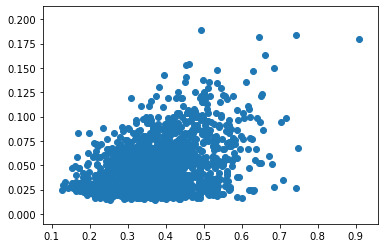

In [98]:
plt.scatter(x,y)